# Entrainement des modèles de régression `sklearn`

**Objectif**

Entrainer un modèle de regréssion à predire les prix d'un type de bien choisi (appartements ou maison) pour une zone géographique donnée (Paris, Marseille, etc.).

**Données**

`DVF+` est une base de données construite à partir des bases de données `DVF` (Demandes de Valeurs Foncières) & `BNB` (Base Nationale des Bâtiments). Cette base a été construite en utilisant les méthodes du module `preprocessing` de la librairie `lib`. 

**Méthode** 

1. Choix d'une zone géographique (`geo_area`) et d'une type de bien (`property_type`)

<br>

2. Préparation du jeu de donneés pour la modélisation 
    - Filtrage des données (nombre de pièces, surface habitable, surface terrain, prix/m²)
    - Application du logarithme à la variable `l_valeur_fonciere`
    - Ajout des variables de tendance des prix du marché: moyenne mobile avec lag de 1 jour appliquée à la variable `valeur_fonciere`
    - Création des dummies 
    - Suppression des variables ayant une proportion de donnnées manquantes trop élevée

<br>

3. Séparation des jeux de données d'entrainement & test
    - Ordonner les transactions par ordre chronologique
    - Les 80% premières transactions sont dans le jeu de données train
    - Les 20% suivantes sont dans le jeu de données test 

<br>

4. Sélection des variables 
    - Calcul de l'information mutuelle (MI) entre les variables explicatives et la cible (`valeur_fonciere` ou `l_valeur_fonciere`)
    - `RandomForestRegressor` pour récupérer l'importance des variables mesurée par la *Mean Decrease Gini* (MDG)
    - Sélection des variables dont l'importance (MI et/ou MDG) est supérieure à seuil prédéfini (ex: quantile d'ordre 75%) 

<br>

5. Entrainement de plusieurs régresseurs
    - A partir des features sélectionnées
    - `LinearRegression`, `DecisionTreeRegressor`, `XGBRegressor`, ... 
    - Diagnostic

<br>

6. Optimisation du type de modèle le + adapté à la prédiction
    - Via [`optuna`](https://optuna.org/)
    - Identification de la combinaison d'hyperparamètres optimales
    - Ré-entrainement du modèle sur le train set 
    - Sauvegarde du modèle et du nom des features

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
from lib.enums import IDF

from lib.dataset import (
    load_dvfplus, 
    prepare_dataset, 
    prepare_dummies, 
    temporal_train_test_split, 
    get_feature_vector, 
    get_target_vector, 
    compute_mutual_info, 
    compute_rf_importances, 
    select_important_features,
)

from lib.dataset.build import (
    add_distance_to_transportation, 
    add_public_facilities
)

from lib.dataset.utils import (
    get_categorical_vars, 
    get_most_frequent_levels,
    transform_price, 
    scale_features
)

from lib.model import (
    CustomRegressor, 
    compute_metrics, 
    display_regression_report, 
    plot_predictions, 
    get_predictions, 
)

from lib.model.optimize import optuna_objective, OptimPruner

from lib.model.loader import save_model, load_model

In [4]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import rich 
from tqdm import tqdm

from multiprocessing import cpu_count

import pickle as pkl

In [5]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler

# estimators
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.neural_network import MLPRegressor

# optimization 
import optuna

In [6]:
# garbage collector
import gc
gc.collect()

0

In [7]:
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

In [8]:
DATA_DIR = "../data/"
BACKUP_DIR = "../backup/"

CPU_COUNT = cpu_count()

## Data

### Import

In [52]:
df_args = {"geo_area": "Paris", "property_type": "flats"}

df = load_dvfplus(zip_dir=DATA_DIR, zip_name="dvf+", **df_args)

C:\Users\pemma\AppData\Local\Temp/ipykernel_19084/175102799.py:3: DtypeWarning: Columns (8,18,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_dvfplus(zip_dir=DATA_DIR, zip_name="dvf+", **df_args)


In [53]:
# add features related to transportation and public facilities 

if df_args["geo_area"] == "Paris":

    transportation = pd.read_csv(f"{DATA_DIR}other/transportation.csv")
    facilities = pd.read_csv(f"{DATA_DIR}other/facilities.csv")

    df = add_distance_to_transportation(df, transportation)
    df = add_public_facilities(df, facilities)

In [54]:
# select specific region or departement 

region = None
departement = "Val-de-Marne"

if df_args["geo_area"] == "urban_areas":

    if region is not None:
        df = df.loc[df.nom_region==region, :]
        
    elif departement is not None:
        df = df.loc[df.nom_departement==departement, :]

In [55]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour,parcelle_id,code_iris,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),baie_u,mur_u_ext,pb_u,ph_u,mur_pos_isol_ext,prc_s_vitree_ext,presence_balcon,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_argiles,alea_radon,distance_transport,nb_coiffure,nb_ecole_maternelle,nb_college,nb_lycee_denseignement_general_et/ou_technologique,nb_medecin_generaliste,nb_pharmacie,nb_institut_universitaire,nb_ecole_dingenieurs,nb_hypermarche,nb_supermarche,nb_grande_surface_de_bricolage,nb_superette,nb_epicerie
0,2017-731653,2017-07-04,1,Vente,571110.0,16.0,NaN,RUE SAINT GILLES,8627,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AM0035,NaN,NaN,12.0,NaN,36.0,49.51,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,42.0,3.0,NaN,NaN,NaN,NaN,NaN,2.366404,48.858043,0,11,Paris,Île-de-France,Paris,34788.0,2017,3,7,4,75103000AM0035,751031102.0,<1948,AVANT_1949,16.0,35.0,269.0,13.0,208.5,4.4,69.0,8.0,485.0,16.0,0.23,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,323.0,0.0,0.0,26.0,23.0,26.0,NaN,Faible,NaN,424.0,0.0,0.0,0.0,318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0
1,2017-731655,2017-07-04,1,Vente,1578150.0,66.0,NaN,RUE DE LISBONNE,5708,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000CO0044,NaN,NaN,61.0,139.02,62.0,NaN,66.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,135.0,4.0,NaN,NaN,NaN,NaN,NaN,2.306998,48.877579,0,11,Paris,Île-de-France,Paris,36453.0,2017,3,7,4,75108000CO0044,751083203.0,<1948,AVANT_1949,20.0,47.0,197.0,40.3,21.3,3.2,181.9,38.0,212.0,42.6,0.18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,NaN,Faible,289.864105,115.0,0.0,0.0,0.0,460.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
2,2017-731657,2017-07-05,1,Vente,2810880.0,27.0,NaN,RUE MARBEUF,5993,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000AR0060,NaN,NaN,93.0,219.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,220.0,6.0,NaN,NaN,NaN,NaN,NaN,2.304234,48.869357,1,11,Paris,Île-de-France,Paris,36453.0,2017,3,7,5,75108000AR0060,751082903.0,<1948,AVANT_1949,24.0,37.0,1604.3,51.6,1283.7,41.8,183.0,5.0,2721.0,88.0,0.03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,271.0,0.0,0.0,164.0,59.0,104.0,NaN,Faible,320.981426,801.0,0.0,0.0,0.0,1869.0,534.0,0.0,0.0,0.0,267.0,0.0,0.0,0.0
3,2017-731658,2017-07-03,1,Vente,130000.0,9.0,NaN,RUE DES INNOCENTS,4718,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AO0081,NaN,NaN,114.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,14.0,1.0,NaN,NaN,NaN,NaN,NaN,2.347393,48.860387,0,11,Paris,Île-de-France,Paris,16252.0,2017,3,7,3,75101000AO0081,751010201.0,<1948,AVANT_1949,19.0,36.0,231.8,7.3,136.2,4.2,53.5,1.7,395.0,12.0,0.03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0

In [56]:
df.shape

(160757, 105)

### Exploration 

L'objectif est de représenter les variables `valeur_fonciere`, `nombre_pieces_principales`, `surface_reelle_bati` et `surface_terrain` pour déterminer ensuite des filtres à appliquer aux données. 

In [17]:
tmp = df.copy()

tmp["valeur_fonciere_m2"] = tmp.apply(
    lambda row: transform_price(row.valeur_fonciere, log=False, area=row.surface_reelle_bati), 
    axis=1
)

Quelques statistiques descriptives relatives aux variables quantitatives qui décrivent les biens. Ces résultats sont utiles pour identifier les valeurs aberrantes et déterminer des seuils. 

In [18]:
vars = ["valeur_fonciere_m2", "surface_reelle_bati", "surface_terrain"]
summary = tmp[vars].describe(percentiles=[.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
summary 

,valeur_fonciere_m2,surface_reelle_bati,surface_terrain
count,1.605160e+05,160591.000000,138.000000
mean,1.063925e+04,53.633460,420.840580
std,1.607979e+04,39.874965,576.248847
min,3.623188e-03,1.000000,33.000000
1%,6.122449e+01,9.000000,36.370000
5%,4.531101e+03,15.000000,51.000000
10%,6.666667e+03,18.000000,70.000000
25%,8.550000e+03,28.000000,144.250000
50%,1.019167e+04,43.000000,210.500000
75%,1.193858e+04,68.000000,453.250000


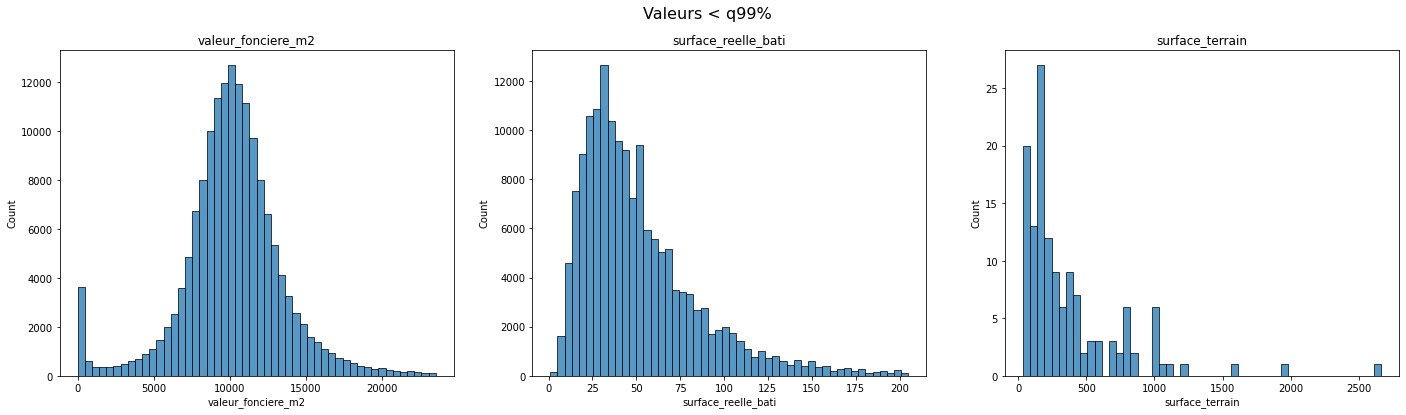

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
fig.suptitle("Valeurs < q99%", fontsize=16)

for var, ax in zip(vars, axes.flatten()): 
    thresold = summary[var]["99%"]

    x = tmp.loc[tmp[var] < thresold, var].dropna()
    sns.histplot(x, ax=ax, bins=50)
    ax.set_title(var);

In [20]:
for var in vars: 
    na_prop = get_na_proportion(tmp, var)
    print(f"{var}: {round(100 * na_prop, 3)}% valeurs manquantes")

valeur_fonciere_m2: 0.047% valeurs manquantes
surface_reelle_bati: 0.001% valeurs manquantes
surface_terrain: 99.914% valeurs manquantes


In [21]:
tmp.nombre_pieces_principales.value_counts(dropna=False, normalize=True)

2.0     0.341194
1.0     0.261570
3.0     0.224631
4.0     0.102216
5.0     0.044380
6.0     0.015885
7.0     0.006034
8.0     0.001862
0.0     0.001220
9.0     0.000467
10.0    0.000293
11.0    0.000106
12.0    0.000037
13.0    0.000019
16.0    0.000012
20.0    0.000012
17.0    0.000012
22.0    0.000006
21.0    0.000006
19.0    0.000006
23.0    0.000006
26.0    0.000006
NaN     0.000006
14.0    0.000006
15.0    0.000006
Name: nombre_pieces_principales, dtype: float64

In [22]:
del tmp 

### Préparation du dataset

Application des filtres statiques sur les variables qui décrivent le bien via le dictionnaire `numeric_filters` : 
- nombre de pièces principales
- surface du bien
- valeur foncière/m² (cf: [meilleursagents](https://www.meilleursagents.com/prix-immobilier/)) 
- surface du terrain (pour les maisons)

Le paramètre `na_thresold` indique la proportion maximale de données manquantes que l'on autorise pour appliquer les techniques d'imputation (par la médiane pour les valeurs numériques, par le mode pour les catégorielles). Les colonnes ayant une proportion de donnnées manquantes supérieures à `na_thresold` sont supprimées. 

Les paramètres de `mov_av_windows` sont utilisées pour calculer les moyennes mobiles du prix moyen journalier ($\approx$ prix du marché à court/moyen/long terme). Notons que l'on applique un lag de 1 jour puisqu'il est nécessaire d'utiliser le prix du marché à la date $t-1$ pour expliquer le prix du bien vendu à la date $t$. Lorsque le paramètre `neighborhood_var` est renseignée, on calcule le prix du marché à court/moyen/long terme par quartier dans la base étudiée. Un quartier peut être un arrondissement, une commune ou un département. 

In [11]:
preproc_args = {

    "numeric_filters": {
        "nombre_pieces_principales": (1, 6), 
        "surface_reelle_bati": (9, 200), 
        "valeur_fonciere_m2": (2000, 20000)
    },  

    "na_threshold": 0.5,

    "mov_av_windows": [7, 14, 30, 90], 

    "neighborhood_var": "arrondissement"
    
}

df_prepoc, dvf_vars, bnb_vars, other_vars = prepare_dataset(df, target_var="l_valeur_fonciere", **preproc_args)

Preprocessing summary:

{
    'created': [
        'l_valeur_fonciere',
        'l_surface_reelle_bati',
        'l_hauteur_mean',
        'l_altitude_sol_mean',
        'l_conso_ener_mean',
        'l_estim_ges_mean',
        'l_conso_ener_min',
        'l_estim_ges_min',
        'l_conso_ener_max',
        'l_estim_ges_max',
        'l_distance_batiment_historique_plus_proche',
        'l_distance_transport',
        'valeur_fonciere_m2',
        'arrondissement',
        'l_valeur_fonciere_ma7',
        'l_valeur_fonciere_ma14',
        'l_valeur_fonciere_ma30',
        'l_valeur_fonciere_ma90'
    ],
    'removed': ['surface_terrain', 'alea_argiles', 'nom_commune']
}

In [12]:
df_prepoc.head()

,id_mutation,date_mutation,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,dependance,nom_departement,trimestre,mois,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),mur_pos_isol_ext,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_radon,distance_transport,nb_coiffure,nb_ecole_maternelle,nb_college,nb_lycee_denseignement_general_et/ou_technologique,nb_medecin_generaliste,nb_pharmacie,nb_institut_universitaire,nb_ecole_dingenieurs,nb_hypermarche,nb_supermarche,nb_grande_surface_de_bricolage,nb_superette,nb_epicerie,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_distance_batiment_historique_plus_proche,l_distance_transport,valeur_fonciere_m2,arrondissement,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90
0,2017-731655,2017-07-04,1578150.0,135.0,4,0,Paris,3,7,<1948,AVANT_1949,20.0,47.0,197.0,40.3,181.9,38.0,212.0,42.6,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,Faible,289.864105,115.0,0.0,0.0,0.0,460.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,5.203457,3.637586,5.356586,3.751854,5.961005,5.669412,11690.000000,8,NaN,NaN,NaN,NaN
1,2017-731658,2017-07-03,130000.0,14.0,1,0,Paris,3,7,<1948,AVANT_1949,19.0,36.0,231.8,7.3,53.5,1.7,395.0,12.0,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,Faible,87.322991,3663.0,0.0,0.0,0.0,2331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666.0,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,3.979682,0.530628,5.978886,2.484907,6.093570,4.469614,9285.714286,1,NaN,NaN,NaN,NaN
2,2017-731661,2017-07-05,485000.0,38.0,3,0,Paris,3,7,<1948,AVANT_1949,18.0,36.0,291.4,37.7,200.0,14.0,447.0,53.2,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,6.0,60.0,40.0,45.0,Faible,101.422809,791.0,0.0,0.0,0.0,226.0,113.0,0.0,0.0,0.0,0.0,0.0,113.0,339.0,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,5.298317,2.639057,6.102559,3.974058,4.615121,4.619298,12763.157895,3,NaN,NaN,NaN,NaN
3,2017-731664,2017-07-11,820000.0,83.0,4,0,Paris,3,7,1970-1988,AVANT_1949,27.0,47.0,459.7,27.3,379.6,21.7,539.7,32.9,0.0,0.0,0.0,non isole,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,164.0,0.0,0.0,32.0,5.0,6.0,Faible,298.755011,1408.0,0.0,0.0,0.0,2112.0,704.0,0.0,0.0,0.0,0.0,0.0,352.0,1408.0,13.617060,4.418841,3.295837,3.850148,6.130574,3.306887,5.939118,3.077312,6.291013,3.493473,5.099866,5.699624,9879.518072,8,13.741994,NaN,NaN,NaN
4,2017-731668,2017-07-07,1414600.0,88.0,3,1,Paris,3,7,<1948,AVANT_1949,19.0,35.0,253.4,37.0,186.0,10.0,326.0,58.1,0.0,0.0,0.0,ITI,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,474.0,0.0,1.0,55.0,40.0,54.0,Faible,241.344815,424.0,0.0,0.0,0.0,318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,14.162357,4.477337,2.944439,3.555348,5.534969,3.610918,5.225747,2.302585,5.786897,4.062166,6.161207,5.486227,16075.000000,3,NaN,NaN,NaN,NaN


In [13]:
df_prepoc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149800 entries, 0 to 149799
Data columns (total 70 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   id_mutation                                               149800 non-null  object 
 1   date_mutation                                             149800 non-null  object 
 2   valeur_fonciere                                           149800 non-null  float64
 3   surface_reelle_bati                                       149800 non-null  float64
 4   nombre_pieces_principales                                 149800 non-null  object 
 5   dependance                                                149800 non-null  int64  
 6   nom_departement                                           149800 non-null  object 
 7   trimestre                                                 149800 non-null  object 
 8   mois

### Encodage des dummies

Cette section permet de transformer les variables catégorielles en variables binaires. Pour chaque variable, la catégorie de référence correspond à la plus fréquente dans le jeu de données. Cette catégorie de référence est ensuite supprimée afin d'éviter tout problème de multicolinéarité dans la matrice des variables explicatives. 

In [18]:
# categorical variable = pandas column with <= 30 unique values

categorical_vars = get_categorical_vars(df_prepoc, n_levels_max=30)   
categorical_vars.append("baie_orientation")

categorical_vars

['nombre_pieces_principales',
 'nom_departement',
 'trimestre',
 'mois',
 'periode_construction',
 'periode_construction_max',
 'mur_pos_isol_ext',
 'alea_radon',
 'arrondissement',
 'baie_orientation']

In [19]:
# select most representative levels for each categorical variable
dummy_ref_levels = get_most_frequent_levels(df_prepoc, categorical_vars)
dummy_ref_levels

{'baie_orientation': 'nord',
 'nombre_pieces_principales': '2',
 'nom_departement': 'Paris',
 'trimestre': '3',
 'mois': '7',
 'periode_construction': '<1948',
 'periode_construction_max': 'AVANT_1949',
 'mur_pos_isol_ext': 'ITI',
 'alea_radon': 'Faible',
 'arrondissement': '18'}

In [20]:
df_prepoc, dvf_vars, bnb_vars, other_vars = prepare_dummies(
    df_prepoc, 
    categorical_vars, 
    dummy_ref_levels, 
    dvf_vars, 
    bnb_vars, 
    other_vars)

Preprocessing summary:

{
    'created': [
        'mois_1',
        'arrondissement_4',
        'nombre_pieces_principales_2',
        'mois_4',
        'mois_10',
        'arrondissement_1',
        'trimestre_4',
        'arrondissement_14',
        'arrondissement_17',
        'arrondissement_2',
        'arrondissement_13',
        'nombre_pieces_principales_5',
        'arrondissement_19',
        'mois_9',
        'mois_12',
        'mois_8',
        'arrondissement_3',
        'mois_6',
        'arrondissement_8',
        'nombre_pieces_principales_6',
        'arrondissement_16',
        'arrondissement_18',
        'arrondissement_12',
        'arrondissement_20',
        'mois_11',
        'arrondissement_5',
        'nombre_pieces_principales_4',
        'arrondissement_6',
        'arrondissement_11',
        'trimestre_2',
        'mois_7',
        'mois_5',
        'nombre_pieces_principales_3',
        'nom_departement_Paris',
        'mois_3',
        'mois_2',
        'nombre_pieces_principales_1',
        'trimestre_3',
        'arrondissement_15',
        'arrondissement_9',
        'trimestre_1',
        'arrondissement_10',
        'arrondissement_7',
        'alea_radon_Faible',
        'periode_construction_bad sup',
        'periode_construction_1949-1970',
        'periode_construction_max_AVANT_1949',
        'periode_construction_max_DE_2001_A_2010',
        'periode_construction_max_DE_1994_A_2000',
        'periode_construction_1970-1988',
        'periode_construction_2006-2012',
        'periode_construction_max_APRES_2011',
        'periode_construction_1989-1999',
        'periode_construction_max_DE_1961_A_1974',
        'periode_construction_max_DE_1949_A_1960',
        'mur_pos_isol_ext_ITI',
        'periode_construction_<1948',
        'mur_pos_isol_ext_ITE+ITR',
        'mur_pos_isol_ext_ITI+ITR',
        'mur_pos_isol_ext_ITR',
        'periode_construction_2000-2005',
        'periode_construction_max_non renseigné',
        'mur_pos_isol_ext_non isole',
        'periode_construction_bad inf',
        'periode_construction_>2012',
        'mur_pos_isol_ext_isole',
        'periode_construction_max_DE_1975_A_1993',
        'mur_pos_isol_ext_ITI+ITE',
        'mur_pos_isol_ext_ITE'
    ],
    'removed': [
        'baie_orientation_nord',
        'nombre_pieces_principales_2',
        'nom_departement_Paris',
        'trimestre_3',
        'mois_7',
        'periode_construction_<1948',
        'periode_construction_max_AVANT_1949',
        'mur_pos_isol_ext_ITI',
        'alea_radon_Faible',
        'arrondissement_18',
        'enr_solaire_thermique_(chauffage)solaire_thermique_(ecs)',
        'enr_solaire_thermique_(ecs+chauffage)'
    ]
}

In [21]:
# set id_mutation as index 

df_prepoc.set_index("id_mutation", inplace=True)

In [22]:
df_prepoc.head()

,date_mutation,valeur_fonciere,surface_reelle_bati,dependance,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,enr_solaire_photovoltaique,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,distance_transport,nb_coiffure,nb_ecole_maternelle,nb_college,nb_lycee_denseignement_general_et/ou_technologique,nb_medecin_generaliste,nb_pharmacie,nb_institut_universitaire,nb_ecole_dingenieurs,nb_hypermarche,nb_supermarche,nb_grande_surface_de_bricolage,nb_superette,nb_epicerie,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_distance_batiment_historique_plus_proche,l_distance_transport,valeur_fonciere_m2,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_1,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1975_A_1993,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-731655,2017-07-04,1578150.0,135.0,0,20.0,47.0,197.0,40.3,181.9,38.0,212.0,42.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,289.864105,115.0,0.0,0.0,0.0,460.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,5.203457,3.637586,5.356586,3.751854,5.961005,5.669412,11690.000000,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-731658,2017-07-03,130000.0,14.0,0,19.0,36.0,231.8,7.3,53.5,1.7,395.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,87.322991,3663.0,0.0,0.0,0.0,2331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666.0,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,3.979682,0.530628,5.978886,2.484907,6.093570,4.469614,9285.714286,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-731661,2017-07-05,485000.0,38.0,0,18.0,36.0,291.4,37.7,200.0,14.0,447.0,53.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,6.0,60.0,40.0,45.0,101.422809,791.0,0.0,0.0,0.0,226.0,113.0,0.0,0.0,0.0,0.0,0.0,113.0,339.0,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,5.298317,2.639057,6.102559,3.974058,4.615121,4.619298,12763.157895,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731664,2017-07-11,820000.0,83.0,0,27.0,47.0,459.7,27.3,379.6,21.7,

In [23]:
rich.print(list(df_prepoc.columns)) 

[
    'date_mutation',
    'valeur_fonciere',
    'surface_reelle_bati',
    'dependance',
    'hauteur_mean',
    'altitude_sol_mean',
    'conso_ener_mean',
    'estim_ges_mean',
    'conso_ener_min',
    'estim_ges_min',
    'conso_ener_max',
    'estim_ges_max',
    'enr_solaire_photovoltaique',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'distance_batiment_historique_plus_proche',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'distance_transport',
    'nb_coiffure',
    'nb_ecole_maternelle',
    'nb_college',
    'nb_lycee_denseignement_general_et/ou_technologique',
    'nb_medecin_generaliste',
    'nb_pharmacie',
    'nb_institut_universitaire',
    'nb_ecole_dingenieurs',
    'nb_hypermarche',
    'nb_supermarche',
    'nb_grande_surface_de_bricolage',
    'nb_superette',
    'nb_epicerie',
    'l_valeur_fonciere',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_distance_batiment_historique_plus_proche',
    'l_distance_transport',
    'valeur_fonciere_m2',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_1',
    'nombre_pieces_principales_3',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'nombre_pieces_principales_6',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1975_A_1993',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'arrondissement_1',
    'arrondissement_10',
    'arrondissement_11',
    'arrondissement_12',
    'arrondissement_13',
    'arrondissement_14',
    'arrondissement_15',
    'arrondissement_16',
    'arrondissement_17',
    'arrondissement_19',
    'arrondissement_2',
    'arrondissement_20',
    'arrondissement_3',
    'arrondissement_4',
    'arrondissement_5',
    'arrondissement_6',
    'arrondissement_7',
    'arrondissement_8',
    'arrondissement_9'
]

La variable cible `l_valeur_fonciere` correspond au logarithme du prix de ventes des biens (`valeur_fonciere`). On décide alors d'exprimer les variables numériques continues sur une échelle logarithmique pour minimiser les effets d'échelle de ces variables. Notons que l'on n'applique pas la transformation logarithmique aux variables numériques discrètes. 

In [24]:
# remove continuous variables which have a counterpart expressed in log scale

to_remove = [
    'valeur_fonciere',
    'valeur_fonciere_m2', 
    'surface_reelle_bati',
    'hauteur_mean',
    'altitude_sol_mean',
    'conso_ener_mean',
    'estim_ges_mean',
    'conso_ener_std',
    'estim_ges_std',
    'conso_ener_min',
    'estim_ges_min',
    'conso_ener_max',
    'estim_ges_max',
    'ratio_ges_conso',
    'distance_transport', 
    'distance_batiment_historique_plus_proche', 
    'nom_commune',
]

to_remove = [col for col in to_remove if col in df_prepoc.columns]

df_prepoc.drop(labels=to_remove, axis=1, inplace=True)

In [25]:
df_prepoc.head()

,date_mutation,dependance,enr_solaire_photovoltaique,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,nb_coiffure,nb_ecole_maternelle,nb_college,nb_lycee_denseignement_general_et/ou_technologique,nb_medecin_generaliste,nb_pharmacie,nb_institut_universitaire,nb_ecole_dingenieurs,nb_hypermarche,nb_supermarche,nb_grande_surface_de_bricolage,nb_superette,nb_epicerie,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_distance_batiment_historique_plus_proche,l_distance_transport,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_1,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1975_A_1993,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-731655,2017-07-04,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,26.0,23.0,23.0,115.0,0.0,0.0,0.0,460.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,5.203457,3.637586,5.356586,3.751854,5.961005,5.669412,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-731658,2017-07-03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147.0,97.0,105.0,3663.0,0.0,0.0,0.0,2331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666.0,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,3.979682,0.530628,5.978886,2.484907,6.093570,4.469614,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-731661,2017-07-05,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,60.0,40.0,45.0,791.0,0.0,0.0,0.0,226.0,113.0,0.0,0.0,0.0,0.0,0.0,113.0,339.0,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,5.298317,2.639057,6.102559,3.974058,4.615121,4.619298,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731664,2017-07-11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,5.0,6.0,1408.0,0.0,0.0,0.0,2112.0,704.0,0.0,0.0,0.0,0.0,0.0,352.0,1408.0,13.617060,4.418841,3.295837,3.850148,6.130574,3.306887,5.939118,3.077312,6.291013,3.493473,5.099866,5.699624,13.741994,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-731668,2017-07-07,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,55.0,40.0,54.0,424.0,0.0,0.0,0.0,318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,14.162357,4.477337,2.944439,3.555348,5.534969

In [26]:
df_prepoc.shape

(149800, 104)

### Train/test split 

Pour obtenir les jeux de données d'entrainement et de test, on applique une séparation temporelle selon la date de transaction (`date_mutation`). Cette méthode est nécessaire puisque la matrice des features comprend des variables représentant l'évolution du prix du marché à court/moyen/long terme (il s'agit des variables de la forme `valeur_fonciere_ma[ma_window]`). Les 80% premières transactions constituent l'échantillon d'entrainement et sont utilisées pour la recherche du meilleur modèle. Les 20% restantes sont utilisées pour tester la performance des modèles. 

In [27]:
df_train, df_test, train_dates, test_dates = temporal_train_test_split(df_prepoc, date_var="date_mutation", train_prop=.8)

In [28]:
print(f"Période d'entrainement : {train_dates.min()} / {train_dates.max()}") 
print(f"Période de test : {test_dates.min()} / {test_dates.max()}") 

Période d'entrainement : 2017-07-01 / 2021-07-20
Période de test : 2021-07-20 / 2022-06-30


In [29]:
target = "l_valeur_fonciere"

X_tr, features = get_feature_vector(df_train, return_features=True, target=target, return_df=False)
y_tr = get_target_vector(df_train, target=target, return_series=False) 

X_te = get_feature_vector(df_test, target=target, return_df=False)
y_te = get_target_vector(df_test, target=target, return_series=False) 

In [30]:
print(f"{X_tr.shape[0]:,} exemples d'entrainement pour {X_tr.shape[1]} features.")
print(f"{X_te.shape[0]:,} exemples test.")

108,315 exemples d'entrainement pour 102 features.
29,938 exemples test.


In [31]:
rich.print(features)

[
    'dependance',
    'enr_solaire_photovoltaique',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'nb_coiffure',
    'nb_ecole_maternelle',
    'nb_college',
    'nb_lycee_denseignement_general_et/ou_technologique',
    'nb_medecin_generaliste',
    'nb_pharmacie',
    'nb_institut_universitaire',
    'nb_ecole_dingenieurs',
    'nb_hypermarche',
    'nb_supermarche',
    'nb_grande_surface_de_bricolage',
    'nb_superette',
    'nb_epicerie',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_distance_batiment_historique_plus_proche',
    'l_distance_transport',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_1',
    'nombre_pieces_principales_3',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'nombre_pieces_principales_6',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1975_A_1993',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'arrondissement_1',
    'arrondissement_10',
    'arrondissement_11',
    'arrondissement_12',
    'arrondissement_13',
    'arrondissement_14',
    'arrondissement_15',
    'arrondissement_16',
    'arrondissement_17',
    'arrondissement_19',
    'arrondissement_2',
    'arrondissement_20',
    'arrondissement_3',
    'arrondissement_4',
    'arrondissement_5',
    'arrondissement_6',
    'arrondissement_7',
    'arrondissement_8',
    'arrondissement_9'
]

## Feature selection 

On applique deux méthodes sur le jeu de données d'entrainement pour identifier les variables explicatives pouvant expliquer au mieux la valeur foncière des biens. 

La première méthode est l'**information mutuelle**. *Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. MI is based on the KL divergence.* On sélectionne ensuite les features ayant une MI supérieure à un certain seuil. 

La seconde méthode consiste à calculér la ***Mean Decrease Gini*** (MDG) à partir de l'estimateur `RandomForestRegressor` et de sélectionner les features ayant une MDG supérieure à certain seuil.  

In [32]:
if len(X_tr) <= 150000:     
    # compute mutual information between features and target
    # if dataset is small enough
    mi_values = compute_mutual_info(X_tr, y_tr, features)

In [33]:
mdg_values = compute_rf_importances(X_tr, y_tr, features)

RandomForestRegressor fitted.
Train MAPE: 0.52%


Une fois les métriques d'importance calculées, on définit des seuils pour la sélection des variables. Par exemple, si le seuil est fixé à `75%`, on sélectionne les variables dont l'importance est supérieure au 3ème quantile des valeurs d'importance. 

In [37]:
mi_threshold = "75%"
mdg_threshold = "75%"

important_features_mi = select_important_features(mi_values, threshold=mi_threshold)
important_features_mdg = select_important_features(mdg_values, threshold=mdg_threshold)

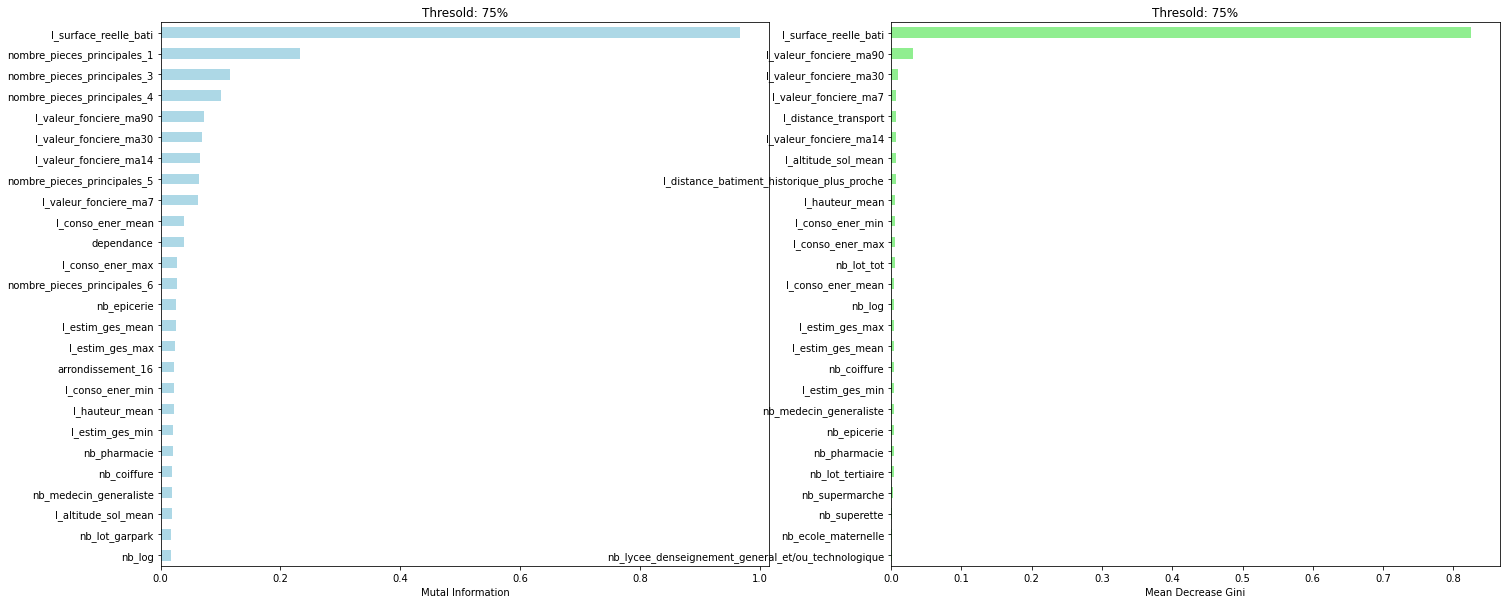

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))

mi_values[important_features_mi]\
    .sort_values()\
    .plot.barh(ax=axes[0], color="lightblue")

axes[0].set_xlabel("Mutal Information")
axes[0].set_title(f"Thresold: {mi_threshold}")

mdg_values[important_features_mdg]\
    .sort_values()\
    .plot.barh(ax=axes[1], color="lightgreen")

axes[1].set_xlabel("Mean Decrease Gini")
axes[1].set_title(f"Thresold: {mdg_threshold}"); 

In [39]:
# get the union of the two sets of important features
selected_features = list(set(important_features_mi + important_features_mdg))

rich.print(f"{len(selected_features)} features sélectionnées")
rich.print(selected_features) 

34 features sélectionnées

[
    'l_estim_ges_mean',
    'l_conso_ener_mean',
    'l_valeur_fonciere_ma7',
    'l_estim_ges_max',
    'nb_coiffure',
    'l_surface_reelle_bati',
    'l_valeur_fonciere_ma90',
    'nb_ecole_maternelle',
    'nb_medecin_generaliste',
    'nb_superette',
    'l_valeur_fonciere_ma14',
    'l_conso_ener_max',
    'nombre_pieces_principales_5',
    'nb_lot_tertiaire',
    'nb_log',
    'l_conso_ener_min',
    'nombre_pieces_principales_6',
    'arrondissement_16',
    'nb_supermarche',
    'l_valeur_fonciere_ma30',
    'l_distance_batiment_historique_plus_proche',
    'l_estim_ges_min',
    'nb_lot_tot',
    'nombre_pieces_principales_4',
    'nb_pharmacie',
    'nb_lot_garpark',
    'nombre_pieces_principales_3',
    'l_distance_transport',
    'l_hauteur_mean',
    'nombre_pieces_principales_1',
    'dependance',
    'nb_lycee_denseignement_general_et/ou_technologique',
    'nb_epicerie',
    'l_altitude_sol_mean'
]

In [40]:
X_tr_reduced = get_feature_vector(df_train, features=selected_features, return_df=False)
X_te_reduced = get_feature_vector(df_test, features=selected_features, return_df=False)

y_tr = get_target_vector(df_train, "l_valeur_fonciere", return_series=False) 
y_te = get_target_vector(df_test, "l_valeur_fonciere", return_series=False)

In [41]:
X_tr_reduced.shape

(108315, 34)

## Modèles de régression 

In [42]:
# indicate if we want to use the reduced feature matrix based on feature selection

use_selected_features = True 

if use_selected_features: 
    X_tr_, X_te_ = X_tr_reduced, X_te_reduced
else:
    X_tr_, X_te_ = X_tr, X_te

### Sans optimisation

L'objectif est d'entrainer plusieurs régresseurs pour déterminer le type de modèle qui semble le plus adapté pour estimer la relation entre `l_valeur_fonciere` et les features sélectionnées. 

Régresseurs :
- `DummyRegressor`, 
- `LinearRegression`, 
- `Ridge`, 
- `DecisionTreeRegressor`, 
- `RandomForestRegressor`, 
- `XGBRegressor`, 
- `MLPRegressor`. 

On garde les paramètres par défaut de chaque estimateur. 

In [43]:
estimators = [
    DummyRegressor(), 
    LinearRegression(),
    Ridge(),
    KNeighborsRegressor(n_neighbors=10),
    SVR(max_iter=2000),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),
    XGBRegressor(), 
]

tree_based = ["DecisionTreeRegressor", "RandomForestRegressor", "XGBRegressor"]

results = {
    "train": {}, 
    "test": {}
}

models = {}

In [44]:
# scale feature matrix for non-tree based models

scaler = MinMaxScaler()

X_tr_scaled, scaler = scale_features(scaler, X_tr_, fit=True)
X_te_scaled = scale_features(scaler, X_te_)

In [45]:
loop = tqdm(estimators) 

for estimator in loop:

    model_name = estimator.__class__.__name__
    model = CustomRegressor(estimator)

    if model_name in tree_based:
        features_tr = X_tr_
        features_te = X_te_
    else: 
        model_name += " (scaled)"
        features_tr = X_tr_scaled
        features_te = X_te_scaled

    loop.set_description(f"Fitting {model_name}...")

    model.fit(features_tr, y_tr)

    models[model_name] = model

    metrics_train = compute_metrics(model, features_tr, y_tr, to_prices=True)
    metrics_test = compute_metrics(model, features_te, y_te, to_prices=True)

    results["train"][model_name] = metrics_train
    results["test"][model_name] = metrics_test

Fitting Ridge (scaled)...: 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]           


In [46]:
display_regression_report(results["train"], title="Metrics computed on valeur_fonciere (train set)")
display_regression_report(results["test"], title="Metrics computed on valeur_fonciere (test set)")

                       Metrics computed on valeur_fonciere (train set)                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DummyRegressor (scaled)     │ 270309.01     │ 64.08        │ 1.76e+11      │ -7.64        │
│ LinearRegression (scaled)   │ 91407.76      │ 20.48        │ 2.35e+10      │ 85.64        │
│ Ridge (scaled)              │ 91417.57      │ 20.48        │ 2.35e+10      │ 85.64        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

                       Metrics computed on valeur_fonciere (test set)                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DummyRegressor (scaled)     │ 289119.72     │ 58.33        │ 2.09e+11      │ -12.13       │
│ LinearRegression (scaled)   │ 92785.19      │ 18.79        │ 2.43e+10      │ 86.93        │
│ Ridge (scaled)              │ 92794.92      │ 18.79        │ 2.43e+10      │ 86.93        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

In [170]:
best_model = models["XGBRegressor"]
best_model 

CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, max_bin=256,
                                       max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=6, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, ...))

In [171]:
preds = get_predictions(best_model, X_te_, y_te)

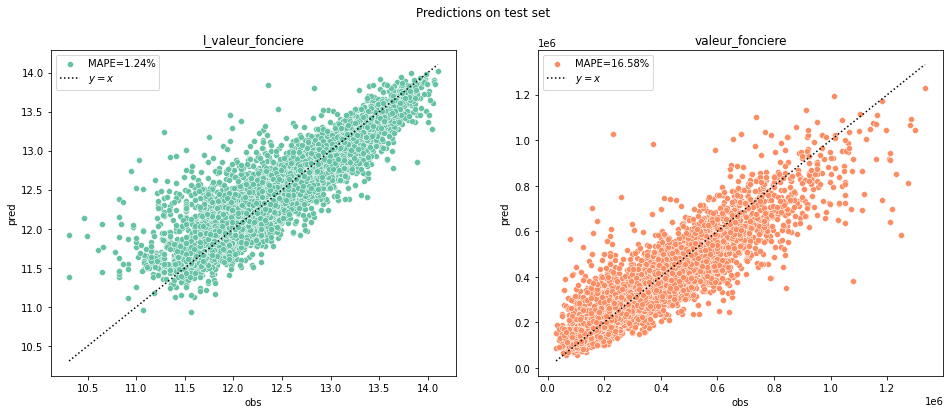

In [172]:
colors = sns.color_palette(palette="Set2", n_colors=2)

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle(f"Predictions on test set", fontsize=12)

for target, ax, color in zip(["l_valeur_fonciere", "valeur_fonciere"], axes.flatten(), colors):

    plot_predictions(
        y_true=preds[target]["y_true"],
        y_pred=preds[target]["y_pred"],
        color=color,
        title=target,
        ax=ax); 

### Optimisation via `optuna`

`optuna` est un framework python permerttant de trouver les paramètres maximisant (ou minimisant) une fonction objectif. `optuna` utilise un historique des essais pour déterminer les valeurs d'hyperparamètres à essayer pour les prochains essais. À l'aide de ces données, il estime les zones les plus prometteuses pour atteindre l'objectif et essaie des valeurs dans cette zone. `optuna` estime ensuite une région encore plus prometteuse sur la base du nouveau résultat, et ainsi de suite jusqu'à convergence de la fonction cible. 

Pour afficher le dashboard résumant l'optimisation : 

```
optuna-dashboard sqlite:///./backup/__optuna/db.sqlite3

Listening on http://localhost:8080/
Hit Ctrl-C to quit.
```

#### Instantiation study `optuna`

In [173]:
pruner = OptimPruner(n_warmup_trials=5, n_trials_to_prune=10)

if departement is not None:
    study_name = f"optim-{departement}-{df_args['property_type']}-xgb-v0".lower()
elif region is not None:
    study_name = f"optim-{region}-{df_args['property_type']}-xgb-v0".lower()
else:
    study_name = f"optim-{df_args['geo_area']}-{df_args['property_type']}-xgb-v0".lower()

optuna_args = {
    "storage": f"sqlite:///{BACKUP_DIR}__optuna/db.sqlite3", 
    "study_name": study_name, 
    "pruner": pruner
}

rich.print(optuna_args)

{
    'storage': 'sqlite:///../backup/__optuna/db.sqlite3',
    'study_name': 'optim-val-de-marne-flats-xgb-v0',
    'pruner': OptimPruner(n_warmup_trials=5, n_trials_to_prune=10)
}

In [174]:
try: 
    study = optuna.create_study(direction="minimize", **optuna_args)
except:
    study = optuna.load_study(**optuna_args)

[I 2023-04-02 15:30:48,075] A new study created in RDB with name: optim-val-de-marne-flats-xgb-v0


#### Recherche modèle optimal

In [175]:
regressor = CustomRegressor(estimator=XGBRegressor())

optim_args = {
    "regressor": regressor,
    "X_tr": X_tr_,
    "y_tr": y_tr,
    "X_te": X_te_,
    "y_te": y_te, 
    "to_prices": False
}

In [176]:
study.optimize(
    func=lambda trial: optuna_objective(trial, **optim_args),
    n_trials=30,
    n_jobs=int(CPU_COUNT / 2),
    show_progress_bar=True
)

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:31:10,595] Trial 1 finished with value: 0.22123940408716145 and parameters: {'n_estimators': 203, 'max_depth': 10, 'learning_rate': 0.002086953505262972, 'subsample': 0.7600096774620554, 'reg_alpha': 0.017308340403401967, 'reg_lambda': 0.014181236115766998}. Best is trial 1 with value: 0.22123940408716145.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:33:40,011] Trial 4 finished with value: 0.012371579100957144 and parameters: {'n_estimators': 986, 'max_depth': 6, 'learning_rate': 0.012230326361472657, 'subsample': 0.9276662459748723, 'reg_alpha': 14.59557871248694, 'reg_lambda': 0.013296509802638364}. Best is trial 4 with value: 0.012371579100957144.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:34:00,139] Trial 2 finished with value: 0.011783986695923222 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.05953482928759431, 'subsample': 0.9757778861167576, 'reg_alpha': 1.3567764588036195, 'reg_lambda': 2.1102499046520626}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:34:04,225] Trial 3 finished with value: 0.011783986695923222 and parameters: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.0033979028115730136, 'subsample': 0.8403410284313116, 'reg_alpha': 0.5878232229373258, 'reg_lambda': 903.1055002487916}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:34:10,919] Trial 0 finished with value: 0.011783986695923222 and parameters: {'n_estimators': 778, 'max_depth': 7, 'learning_rate': 0.038814131567646896, 'subsample': 0.8962105752831311, 'reg_alpha': 0.45660699032539376, 'reg_lambda': 443.6408424318507}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:34:24,650] Trial 6 finished with value: 0.4198307454698707 and parameters: {'n_estimators': 529, 'max_depth': 9, 'learning_rate': 0.0015802669759461636, 'subsample': 0.8304680215300847, 'reg_alpha': 0.007150811323208253, 'reg_lambda': 107.9623201193139}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:34:42,604] Trial 7 finished with value: 0.012644126459487981 and parameters: {'n_estimators': 246, 'max_depth': 4, 'learning_rate': 0.04829800569242173, 'subsample': 0.625472101804757, 'reg_alpha': 0.0026496304771609887, 'reg_lambda': 0.0037152766691987515}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:35:26,930] Trial 9 finished with value: 0.09284549309284824 and parameters: {'n_estimators': 505, 'max_depth': 10, 'learning_rate': 0.004637953666399232, 'subsample': 0.6108595165345116, 'reg_alpha': 9.267714373033193, 'reg_lambda': 0.10370522414100608}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:35:38,814] Trial 5 finished with value: 0.013234525873642806 and parameters: {'n_estimators': 346, 'max_depth': 8, 'learning_rate': 0.01582962181435115, 'subsample': 0.690320916236553, 'reg_alpha': 0.823414954698087, 'reg_lambda': 0.07199134598971274}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:35:53,831] Trial 8 finished with value: 0.012855429207258663 and parameters: {'n_estimators': 955, 'max_depth': 3, 'learning_rate': 0.01554708033824123, 'subsample': 0.67342557276409, 'reg_alpha': 3.4022164626416687, 'reg_lambda': 10.702927510528193}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:36:04,526] Trial 10 finished with value: 0.14612061538666793 and parameters: {'n_estimators': 524, 'max_depth': 6, 'learning_rate': 0.003592850457525967, 'subsample': 0.8948174394315016, 'reg_alpha': 0.35940211610066175, 'reg_lambda': 1.336310526553831}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:36:15,979] Trial 11 finished with value: 0.03259593568063125 and parameters: {'n_estimators': 522, 'max_depth': 3, 'learning_rate': 0.006620552862434826, 'subsample': 0.5282021351039747, 'reg_alpha': 1.7562052373113877, 'reg_lambda': 0.2499098590553319}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:36:39,426] Trial 13 finished with value: 0.01545923353797073 and parameters: {'n_estimators': 735, 'max_depth': 7, 'learning_rate': 0.0919796709477061, 'subsample': 0.505441452405286, 'reg_alpha': 436.1665113860557, 'reg_lambda': 28.301801097537655}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:36:47,227] Trial 14 finished with value: 0.01402412523234353 and parameters: {'n_estimators': 773, 'max_depth': 5, 'learning_rate': 0.0954568191442441, 'subsample': 0.5237796715139034, 'reg_alpha': 191.8833617563856, 'reg_lambda': 10.274378365029827}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:37:03,357] Trial 15 finished with value: 0.013227441693783351 and parameters: {'n_estimators': 775, 'max_depth': 5, 'learning_rate': 0.07108117872552369, 'subsample': 0.9923358896952037, 'reg_alpha': 110.773332169778, 'reg_lambda': 9.373437550963736}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:38:12,381] Trial 12 finished with value: 0.011800547002950508 and parameters: {'n_estimators': 763, 'max_depth': 6, 'learning_rate': 0.038037348975185986, 'subsample': 0.9641521170592263, 'reg_alpha': 0.003955085894225303, 'reg_lambda': 4.206373289606906}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:38:26,802] Trial 16 finished with value: 0.011955331248217937 and parameters: {'n_estimators': 777, 'max_depth': 5, 'learning_rate': 0.037213931804558655, 'subsample': 0.9967187375978963, 'reg_alpha': 0.06293284413824836, 'reg_lambda': 2.520106344106678}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:39:36,498] Trial 17 finished with value: 0.011959644598455032 and parameters: {'n_estimators': 783, 'max_depth': 7, 'learning_rate': 0.038136680111401595, 'subsample': 0.9899057667562583, 'reg_alpha': 0.04564840851546243, 'reg_lambda': 841.5906635862628}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:40:04,722] Trial 18 finished with value: 0.011975602070928156 and parameters: {'n_estimators': 873, 'max_depth': 7, 'learning_rate': 0.03250294608051421, 'subsample': 0.9898479803316799, 'reg_alpha': 0.09982090305399531, 'reg_lambda': 845.7237347431364}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:41:05,297] Trial 19 finished with value: 0.01200992605762867 and parameters: {'n_estimators': 679, 'max_depth': 8, 'learning_rate': 0.02829250475866141, 'subsample': 0.7908306200265788, 'reg_alpha': 0.05589810535963067, 'reg_lambda': 751.0520490633888}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:41:58,446] Trial 22 finished with value: 0.01229415100336729 and parameters: {'n_estimators': 609, 'max_depth': 8, 'learning_rate': 0.022393049500594855, 'subsample': 0.7718481773686209, 'reg_alpha': 16.392270537893282, 'reg_lambda': 138.8542893506989}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:42:01,966] Trial 23 finished with value: 0.012934604912572594 and parameters: {'n_estimators': 628, 'max_depth': 4, 'learning_rate': 0.017835295397446948, 'subsample': 0.8641422950149336, 'reg_alpha': 20.61172900872728, 'reg_lambda': 44.85425784226129}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:42:12,388] Trial 24 finished with value: 0.6300991952279924 and parameters: {'n_estimators': 408, 'max_depth': 9, 'learning_rate': 0.0010422003388676489, 'subsample': 0.8676699797159775, 'reg_alpha': 0.29381637110170244, 'reg_lambda': 143.5239968304551}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:42:19,316] Trial 21 finished with value: 0.011844868528234432 and parameters: {'n_estimators': 647, 'max_depth': 8, 'learning_rate': 0.021822385798179775, 'subsample': 0.7786834835983988, 'reg_alpha': 0.16446177199152512, 'reg_lambda': 102.92551517317754}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:42:24,129] Trial 20 finished with value: 0.011926904733914024 and parameters: {'n_estimators': 908, 'max_depth': 8, 'learning_rate': 0.01982951162607772, 'subsample': 0.7834456025957257, 'reg_alpha': 0.09048415390429666, 'reg_lambda': 432.4717774411138}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:42:30,128] Trial 25 finished with value: 0.05538780692685277 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.008084469313360935, 'subsample': 0.8593741727763737, 'reg_alpha': 0.24474057217300185, 'reg_lambda': 303.9638286450261}. Best is trial 2 with value: 0.011783986695923222.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 1.0),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:30: FutureWarning: suggest_loguniform has been deprecated 

[I 2023-04-02 15:43:59,589] Trial 28 finished with value: 0.013055907169760104 and parameters: {'n_estimators': 849, 'max_depth': 4, 'learning_rate': 0.008516991381760984, 'subsample': 0.9210508751193839, 'reg_alpha': 0.6691571601514855, 'reg_lambda': 0.4067620520160275}. Best is trial 2 with value: 0.011783986695923222.
[I 2023-04-02 15:44:08,272] Trial 29 finished with value: 0.011933457266011738 and parameters: {'n_estimators': 898, 'max_depth': 4, 'learning_rate': 0.05711124948056636, 'subsample': 0.918096992575268, 'reg_alpha': 1.1125092214816137, 'reg_lambda': 0.3124112430859669}. Best is trial 2 with value: 0.011783986695923222.
[I 2023-04-02 15:44:38,859] Trial 26 finished with value: 0.014092584437589024 and parameters: {'n_estimators': 892, 'max_depth': 9, 'learning_rate': 0.006749665346598277, 'subsample': 0.8192260948836879, 'reg_alpha': 0.4544640764521074, 'reg_lambda': 293.9024332117112}. Best is trial 2 with value: 0.011783986695923222.
[I 2023-04-02 15:45:12,727] Trial 

In [178]:
rich.print(study.best_trial) 

FrozenTrial(number=2, values=[0.011783986695923222], datetime_start=datetime.datetime(2023, 
4, 2, 15, 30, 57, 243103), datetime_complete=datetime.datetime(2023, 4, 2, 15, 34, 0, 68290),
params={'learning_rate': 0.05953482928759431, 'max_depth': 5, 'n_estimators': 933, 
'reg_alpha': 1.3567764588036195, 'reg_lambda': 2.1102499046520626, 'subsample': 
0.9757778861167576}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, 
low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'reg_alpha': 
FloatDistribution(high=1000.0, log=True, low=0.001, step=None), 'reg_lambda': 
FloatDistribution(high=1000.0, log=True, low=0.001, step=None), 'subsample': 
FloatDistribution(high=1.0, log=True, low=0.5, step=None)}, user_attrs={}, system_attrs={}, 
intermediate_values={}, trial_id=158, state=TrialState.COMPLETE, value=None)

#### Ré-entrainement

Utilisation des hyperparamètres optimaux pour entrainer `XGBRegressor`. 

In [179]:
params_opt = study.best_params
rich.print(params_opt)

xgb_opt = CustomRegressor(estimator=XGBRegressor(**params_opt))

{
    'learning_rate': 0.05953482928759431,
    'max_depth': 5,
    'n_estimators': 933,
    'reg_alpha': 1.3567764588036195,
    'reg_lambda': 2.1102499046520626,
    'subsample': 0.9757778861167576
}

In [180]:
xgb_opt.fit(X_tr_, y_tr)

CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.05953482928759431,
                                       max_bin=256, max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=5, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=933, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, ...))

In [181]:
if use_selected_features: 
    feature_names = selected_features
else:
    feature_names = features

if departement is not None:
    geo_area = departement
elif region is not None:
    geo_area = region
else:
    geo_area = df_args["geo_area"]

backup_args = {
    "version": 0, 
    "geo_area": geo_area, 
    "property_type": "flats"
}

backup_args

{'version': 0, 'geo_area': 'Val-de-Marne', 'property_type': 'flats'}

In [182]:
save_model(
    path=f"{BACKUP_DIR}/models",
    model=xgb_opt, 
    feature_names=feature_names, 
    **backup_args)

XGBRegressor and feature names saved at ../backup//models/xgbregressor-val-de-marne-flats-v0.pkl


#### Diganostic modèle optimal

In [183]:
xgb_loader = load_model(
    path=f"{BACKUP_DIR}/models",
    estimator_name="XGBRegressor", 
    **backup_args)

In [184]:
xgb_opt = xgb_loader["model"]

feature_names = xgb_loader["feature_names"]
rich.print(f"Features used to fit model:\n{feature_names}")

Features used to fit model:
['l_valeur_fonciere_ma30', 'l_altitude_sol_mean', 'l_conso_ener_min', 'l_conso_ener_mean', 
'l_estim_ges_mean', 'nombre_pieces_principales_4', 'baie_orientation_indetermine', 
'nombre_pieces_principales_6', 'l_surface_reelle_bati', 'periode_construction_2000-2005', 
'periode_construction_max_DE_1975_A_1993', 'periode_construction_max_AVANT_1949', 
'periode_construction_max_DE_2001_A_2010', 'trimestre_1', 'nb_log', 
'nombre_pieces_principales_2', 'l_estim_ges_std', 'l_estim_ges_min', 'nb_lot_garpark', 
'l_conso_ener_std', 'nb_lot_tertiaire', 'alea_argiles_Fort', 'nombre_pieces_principales_5', 
'l_conso_ener_max', 'l_valeur_fonciere_ma7', 'l_valeur_fonciere_ma14', 
'periode_construction_max_APRES_2011', 'periode_construction_2006-2012', 'l_hauteur_mean', 
'l_estim_ges_max', 'l_ratio_ges_conso', 'dependance', 'nombre_pieces_principales_1', 
'l_valeur_fonciere_ma90', 'nb_lot_tot', 'qpv']

In [185]:
xgb_opt_metrics = {
    "train": {"XGBRegressor": compute_metrics(xgb_opt, X_tr_, y_tr)}, 
    "test": {"XGBRegressor": compute_metrics(xgb_opt, X_te_, y_te)}
}

In [186]:
display_regression_report(xgb_opt_metrics["train"], title="Fine-tuned XGBRegressor metrics (train set)")
display_regression_report(xgb_opt_metrics["test"], title="Fine-tuned XGBRegressor metrics (test set)")

                         Fine-tuned XGBRegressor metrics (train set)                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 31488.21      │ 12.89        │ 2.43e+09      │ 89.85        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

                         Fine-tuned XGBRegressor metrics (test set)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 40504.96      │ 15.86        │ 3.80e+09      │ 85.85        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

In [187]:
xgb_preds = {
    "train": get_predictions(xgb_opt, X_tr_, y_tr), 
    "test": get_predictions(xgb_opt, X_te_, y_te)
}

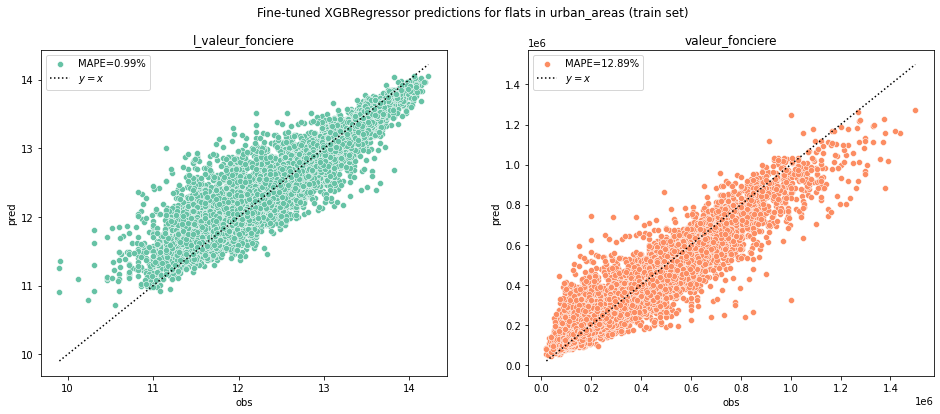

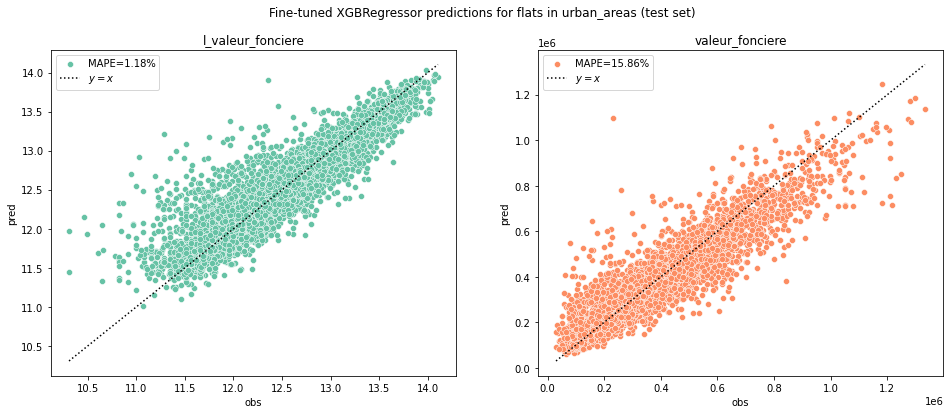

In [188]:
colors = sns.color_palette(palette="Set2", n_colors=2)

for dataset, preds in xgb_preds.items():

    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    title = f"Fine-tuned XGBRegressor predictions for {df_args['property_type']} in {df_args['geo_area']} ({dataset} set)"
    fig.suptitle(title, fontsize=12)

    for target, ax, color in zip(["l_valeur_fonciere", "valeur_fonciere"], axes.flatten(), colors):

        plot_predictions(
            y_true=preds[target]["y_true"],
            y_pred=preds[target]["y_pred"],
            color=color,
            title=target,
            ax=ax);